In [1]:
using HomotopyContinuation

In [126]:
PRINT_ROOTS = false # Output roots to console in algorithms

false

# Initialize system

In [127]:
# Example: 4-cyclic polynomial (4 variables, 17 parameters, has 24 solutions)
N_SOLS = 24

# Define variables and parameters
num_parameters = 17
num_variables = 4
@var p[1:num_parameters]
@var x[1:num_variables]

# Define parametrized family of sparse systems (different polynomials don't contain same monomial, each monomial has a distinct parameter)
F = System([p[1]*x[1]+p[2]*x[2]+p[3]*x[3]+p[4]*x[4],
p[5]*x[1]*x[2] + p[6]*x[2]*x[3] + p[7]*x[1]*x[3] + p[8]*x[1]*x[4] + p[9]*x[2]*x[4] + p[10]*x[3]*x[4],
p[11]*x[1]*x[2]*x[3] + p[12]*x[1]*x[2]*x[4] + p[13]*x[1]*x[3]*x[4] + p[15]*x[2]*x[3]*x[4],
p[16]*x[1]*x[2]*x[3]*x[4]-p[17]], variables=x, parameters=p)


System of length 4
 4 variables: x₁, x₂, x₃, x₄
 17 parameters: p₁, p₂, p₃, p₄, p₅, p₆, p₇, p₈, p₉, p₁₀, p₁₁, p₁₂, p₁₃, p₁₄, p₁₅, p₁₆, p₁₇

 p₁*x₁ + p₂*x₂ + p₃*x₃ + p₄*x₄
 p₅*x₂*x₁ + p₆*x₂*x₃ + p₇*x₃*x₁ + p₈*x₄*x₁ + p₉*x₄*x₂ + x₄*x₃*p₁₀
 x₂*x₃*x₁*p₁₁ + x₄*x₂*x₁*p₁₂ + x₄*x₂*x₃*p₁₅ + x₄*x₃*x₁*p₁₃
 -p₁₇ + x₄*x₂*x₃*x₁*p₁₆

##### Seeding
Choose a generic system and find a solution using Newton's method

In [98]:
newton_start = generate_generic_points(num_variables)
p0 = generate_generic_points(num_parameters)
F0 = System(evaluate(expressions(F),  p => p0))
search_seed = newton(F0, newton_start)
while search_seed.return_code != :success
    newton_start = generate_generic_points(num_variables)
    search_seed = newton(F0, newton_start)
end
x0 = search_seed.x


4-element Vector{ComplexF64}:
 -0.17298317354692597 + 0.7123112569807911im
 -0.07307495963558244 + 0.8854217377888782im
   0.8874813835877802 + 0.7392893475471439im
  0.21945096996024036 - 0.5214980417444863im

##### Auxiliary functions

In [88]:
using Random
rng = MersenneTwister()  # Create a random number generator

function vprod(a, b)
    # Multiplies two matrices
    res = 0
    for i in 1:length(a)
        res += a[i]*b[i]
    end
    return res
end

function generate_generic_points(N)
    numbers = Array{Complex{Float64}}(undef, N)  # Initialize an array of Complex{Float64}
    for i in 1:N
        real_part = rand(rng, -1.0:0.01:1.0)  # Generate a random real part between -1 and 1
        imag_part = rand(rng, -1.0:0.01:1.0)  # Generate a random imaginary part between -1 and 1
        numbers[i] = complex(real_part, imag_part)  # Create a complex number
    end

    return numbers
end

function create_random_parameters()
    # Returns a vector of random parameters
    random_parameters = generate_generic_points(num_parameters)
    return random_parameters
end

function nest_list(list)
    # Given a list returns the list of each member as a one element list
    return [[list[i]] for i in 1:length(list)]
end

function print_vector(vector::Vector{Vector{ComplexF64}}, sentence="")
    string_vector = [string(x[1]) for x in vector]
    println(sentence,join(string_vector, ", "))
end

function print_solutions(solutions, sentenceS="", sentenceE="")
    if !PRINT_ROOTS
        return
    end

    result = ""
    for sol in solutions
        result *= "\n - "
        sol_string = [string(x) for x in sol]
        result *= join(sol_string, ", ")
    end
    # Remove last comma
    result = result[1:end-2]
    if sentenceE != ""
        result *= "\n"
    end
    println(sentenceS, result, sentenceE)
end

function is_in_aprox(list, element, precision=1e-5)
    # Check if the element is in the list up to a certain precision
    if length(list) == 0
        return false
    end
    for i in 1:length(list)
        if (norm(element .- list[i]) < precision)
            return true
        end
    end
    return false
end

function createEdge(p1, p2, k1=nothing, k2=nothing)
    # p_1 and p_2 are the parameters of two systems
    # returns a the straight line homotopy from k1*F_p1 to k2*F_p2 for generic k1, k2
    if k1==nothing
        k1,k2 = generate_generic_points(2)
    end
    Fs = System(k1*evaluate(expressions(F),  p => p1))
    Gs = System(k2*evaluate(expressions(F),  p => p2))
    H = StraightLineHomotopy(Fs, Gs)
    return H
end

createEdge (generic function with 3 methods)

# Graph layouts

##### Graph objects creation

In [28]:
mutable struct Vertex
    known_roots
    base_point
    label::Int
    Vertex(known_roots, base_point) = new(known_roots, base_point, 0)
end

mutable struct Edge
    startV::Vertex
    tracker_start::Tracker
    endV::Vertex
    tracker_end::Tracker
    parameters::Vector{ComplexF64}
    tracked_roots_start
    tracked_roots_end
    label::Vector{Int}
    label_id::Int
    Edge(startV, tracker_start, endV, tracker_end, parameters) = new(startV, tracker_start, endV, tracker_end, parameters, [], [], [], 0)
end

mutable struct Graph
    vertices::Vector{Vertex}
    edges::Vector{Edge}
    paths_tracked::Int
    path_tracking
    new_solution::Int
    vertex_labels::Vector{Int}
    edge_labels::Vector{Vector{Int}}
    history::Vector{Graph}
end

# Change function to use labels
function still_untracked_roots(G)
    # Go through all the edges and check if there are still untracked roots
    for i = 1:length(G.edges)
        # If there are roots in start or end nodes that are not tracked, return true
        if length(G.edges[i].tracked_roots_start) < length(G.edges[i].startV.known_roots)
            return true, G.edges[i]
        end
        if length(G.edges[i].tracked_roots_end) < length(G.edges[i].endV.known_roots)
            return true, G.edges[i]
        end
    end
    return false, nothing
end


function createGraph()
    return Graph([], [], 0, [], 0, [], [], [])
end

function light_graph_copy(G)
    # Return a copy of the graph without the history, edges and vertices
    return Graph(G.vertices, [], G.paths_tracked, G.path_tracking, G.new_solution, G.vertex_labels, G.edge_labels, [])
end

function save_graph_history(G)
    # Create a copy
    G_copy = deepcopy(light_graph_copy(G))
    # Save the graph to the history
    push!(G.history, G_copy)
end

function add_Vertex(G, vertex)
    # Save to history
    save_graph_history(G)
    # Generate vertex id
    vertex.label = length(G.vertices) + 1

    println("Created vertex: ", vertex.label)

    # Add it to the graph
    push!(G.vertices, vertex)
    # Add the label to the list of labels
    push!(G.vertex_labels, vertex.label)
end

function add_Edge(G, edge)
    # Save to history
    save_graph_history(G)
    # Generate edge label
    edge.label = [min(edge.startV.label, edge.endV.label), max(edge.startV.label, edge.endV.label)]
    # Generate edge dependent on other edges between same vertices
    previous_edge_index = [i for i in length(G.edge_labels):-1:1 if G.edge_labels[i] == edge.label]
    if previous_edge_index != []
        edge.label_id = G.edges[previous_edge_index[1]].label_id + 1
    else
        edge.label_id = 1
    end
    # Add the label to the list of labels
    push!(G.edge_labels, edge.label)
    println("Created edge ", edge.label, "#", edge.label_id, "  (k1: ", edge.parameters[1], " k2: ", edge.parameters[2], ")")

    # Add it to the graph
    push!(G.edges, edge)
end

function track_path(G, edge, roots, fromStart)
    # Save before
    save_graph_history(G)

    vertex = fromStart ? edge.startV : edge.endV
    if(length(roots) == 0)
        println("No roots to track from ", vertex.label, ".")
        return []
    end

    tracker = fromStart ? edge.tracker_start : edge.tracker_end
    println("Tracking roots through path ", edge.label, "#", edge.label_id, " from ", vertex.label)
    print_solutions(roots, "Roots: ")
    G.path_tracking = [edge.label, edge.label_id, edge.startV.label]
    G.paths_tracked += length(roots)

    # Reset the path tracking
    save_graph_history(G)
    G.path_tracking = []
    
    return track.(tracker, roots)
end

function add_root(G, edge, vertex_end, root_start, root_end)
    # A root only is tracked once so we record it in the edge
    push!(edge.tracked_roots_start, root_start)

    # Check if the root is already in the end vertex
    if !is_in_aprox(edge.tracked_roots_end, root_end)
        push!(edge.tracked_roots_end, root_end)
    end
    if !is_in_aprox(vertex_end.known_roots, root_end)
        print_solutions([root_end], "Adding root: ")
        
        save_graph_history(G)
        G.new_solution = vertex_end.label
        push!(vertex_end.known_roots, root_end)
        save_graph_history(G)
    end
end

add_root (generic function with 1 method)

## Flower graph

In [57]:
function create_flower_graph(seed,s,t)
    F0, x0 = seed
    initial_vertex = Vertex([x0], p0)
    flower_graph = createGraph()
    add_Vertex(flower_graph, initial_vertex)
    for i = 1:s
        # Create a new vertex
        new_vsystem = create_random_parameters()
        new_vertex = Vertex([], new_vsystem)

        add_Vertex(flower_graph, new_vertex)
        
        for j = 1:t
            k1,k2 = generate_generic_points(2)
            new_homotopy1 = createEdge(initial_vertex.base_point, new_vertex.base_point, k1,k2)
            new_tracker1 = Tracker(new_homotopy1)
            new_homotopy2 = createEdge(new_vertex.base_point, initial_vertex.base_point, k2, k1)
            new_tracker2 = Tracker(new_homotopy2)

            new_edge = Edge(initial_vertex, new_tracker1, new_vertex, new_tracker2, [k1, k2])
            add_Edge(flower_graph, new_edge)
        end
    end
    return flower_graph
end

create_flower_graph (generic function with 1 method)

In [58]:
G = create_flower_graph((F,seed), 2, 2);

Created vertex: 1
Created vertex: 2
Created edge [1, 2]#1  (k1: 0.99 - 0.67im k2: 0.53 + 0.92im)
Created edge [1, 2]#2  (k1: 0.89 + 0.57im k2: -0.24 + 0.27im)
Created vertex: 3
Created edge [1, 3]#1  (k1: 1.0 - 0.07im k2: -0.37 + 0.92im)
Created edge [1, 3]#2  (k1: -0.34 - 0.42im k2: -0.64 + 0.47im)


## Complete graph

In [69]:
function create_complete_graph(s,t)

    complete_graph = createGraph()
    # Create vertices
    for i = 1:s
        # Create a new vertex
        new_vsystem = create_random_parameters()
        new_vertex = Vertex([], new_vsystem)
        add_Vertex(complete_graph, new_vertex)        
    end

    for i = 1:s
        for i_end = (i+1):s
            # Create t edges (i,i_end)
            for j = 1:t
                k1,k2 = generate_generic_points(2)
                println("Creating edge ", i, " ", j)
                println("k1: ", k1, " k2: ", k2)
                new_homotopy1 = createEdge(complete_graph.vertices[i].base_point, complete_graph.vertices[i_end].base_point, k1,k2)
                new_tracker1 = Tracker(new_homotopy1)

                new_homotopy2 = createEdge(complete_graph.vertices[i_end].base_point, complete_graph.vertices[i].base_point, k2, k1)
                new_tracker2 = Tracker(new_homotopy2)

                new_edge = Edge(complete_graph.vertices[i], new_tracker1, complete_graph.vertices[i_end], new_tracker2, [k1, k2])
                add_Edge(complete_graph, new_edge)                
            end
        end
    end
    return complete_graph
end

create_complete_graph (generic function with 1 method)

In [70]:
G = create_complete_graph(4, 1);

Created vertex: 1
Created vertex: 2
Created vertex: 3
Created vertex: 4
Creating edge 1 1
k1: -0.75 + 0.26im k2: 0.06 + 0.17im
Created edge [1, 2]#1  (k1: -0.75 + 0.26im k2: 0.06 + 0.17im)
Creating edge 1 1
k1: 0.27 - 0.39im k2: 0.35 - 0.27im
Created edge [1, 3]#1  (k1: 0.27 - 0.39im k2: 0.35 - 0.27im)
Creating edge 1 1
k1: 0.0 - 0.53im k2: 0.69 + 0.12im
Created edge [1, 4]#1  (k1: 0.0 - 0.53im k2: 0.69 + 0.12im)
Creating edge 2 1
k1: -0.97 - 0.41im k2: -0.79 + 0.62im
Created edge [2, 3]#1  (k1: -0.97 - 0.41im k2: -0.79 + 0.62im)
Creating edge 2 1
k1: 0.13 - 0.24im k2: -0.24 - 0.8im
Created edge [2, 4]#1  (k1: 0.13 - 0.24im k2: -0.24 - 0.8im)
Creating edge 3 1
k1: -0.86 - 0.54im k2: -0.89 + 0.62im
Created edge [3, 4]#1  (k1: -0.86 - 0.54im k2: -0.89 + 0.62im)


# Naive dynamic strategy

In [100]:
function naive_dynamic_strategy()
    # Given the seed (F_0, x_0) uses the naive dynamic strategy to compute the roots of F_0
    roots = [x0]
    paths_tracked = 0

    iteration = 0
    while length(roots) < N_SOLS && iteration < 100
        # Create a new vertex
        G = create_random_parameters()

        # Create the edge from F_0 to G
        H1 = createEdge(p0, G)
        tracker1 = Tracker(H1)

        # Create the edge from G to F_0
        H2 = createEdge(G, p0)
        tracker2 = Tracker(H2)

        # Track all the known roots
        println("========Adding petal========")
        print_solutions(roots, "<starting edge>\n")
        track_vertex_roots = track.(tracker1, roots)
        paths_tracked += length(roots)

        vertex_roots = [track_vertex_roots[i].solution for i = 1:length(track_vertex_roots)]
        print_solutions(vertex_roots, "<intermediary edge>\n")

        root_potential = track.(tracker2, vertex_roots)
        paths_tracked += length(vertex_roots)

        for i in 1:size(root_potential,1)
            # If the root is not already in the list, add it
            #println("Checking if found root ", i, " out of ",size(root_potential,1),":\n", root_potential[i].solution)
            if !is_in_aprox(roots, root_potential[i].solution) 
                println("+Adding new root")
                push!(roots, root_potential[i].solution)
            end
        end
        iteration += 1
        println("Known roots: ",length(roots))

    end
    if iteration == 100
        println("Stopped after 100 iterations.")
    else
        println("Finished in ", iteration, " iterations.")
    end
    println("Paths tracked: ", paths_tracked)
    return roots
end
        

naive_dynamic_strategy (generic function with 1 method)

In [107]:
naive_dynamic_strategy()

========Adding petal========
+Adding new root
Known roots: 2
========Adding petal========
+Adding new root
+Adding new root
Known roots: 4
========Adding petal========
+Adding new root
+Adding new root
+Adding new root
+Adding new root
Known roots: 8
========Adding petal========
Known roots: 8
========Adding petal========
+Adding new root
+Adding new root
+Adding new root
Known roots: 11
========Adding petal========
+Adding new root
+Adding new root
+Adding new root
+Adding new root
Known roots: 15
========Adding petal========
+Adding new root
+Adding new root
+Adding new root
+Adding new root
+Adding new root
+Adding new root
Known roots: 21
========Adding petal========
+Adding new root
+Adding new root
+Adding new root
Known roots: 24
Finished in 8 iterations.
Paths tracked: 140


24-element Vector{Vector{ComplexF64}}:
 [-0.17298317354692597 + 0.7123112569807911im, -0.07307495963558244 + 0.8854217377888782im, 0.8874813835877802 + 0.7392893475471439im, 0.21945096996024036 - 0.5214980417444863im]
 [-0.20697941278848653 - 0.7784923586506524im, -0.5136924010620649 + 2.6208406311797536im, -0.03779814253743583 - 0.15639930153610168im, 0.17898269336336062 - 1.2163919850260312im]
 [0.17298317354692583 - 0.7123112569807911im, 0.07307495963558265 - 0.8854217377888781im, -0.8874813835877805 - 0.7392893475471438im, -0.21945096996024044 + 0.5214980417444864im]
 [-0.40335902235129056 + 0.12550871286162238im, 1.1657113805442756 - 1.7737108501643348im, 1.1801418297518524 + 0.5373375060532518im, 0.278458850540135 + 0.23761247459689994im]
 [-0.5370219101946327 - 2.6166086427437873im, 1.0970231445078558 + 0.7195534421038746im, 0.038332654995965075 - 0.12636468539812495im, 0.6206960883789941 - 0.6786502644213633im]
 [0.20697941278848656 + 0.7784923586506522im, 0.5136924010620655 - 

# Static strategy

In [108]:
function static_graph_strategy(G, N_bound)
    condition, edge_focus = still_untracked_roots(G)
    if !condition
        println("Graph is already fully tracked.")
        return
    end
    while condition && length(G.vertices[1].known_roots) < N_bound
        println("--------------------------Edge ", edge_focus.label, " has untracked roots----------------------")
        # Get the untracked roots
        untracked_roots_start = [edge_focus.startV.known_roots[i] for i in 1:length(edge_focus.startV.known_roots) if !is_in_aprox(edge_focus.tracked_roots_start, edge_focus.startV.known_roots[i])]
        untracked_roots_end = [edge_focus.endV.known_roots[i] for i in 1:length(edge_focus.endV.known_roots) if !is_in_aprox(edge_focus.tracked_roots_end, edge_focus.endV.known_roots[i])]

        track_points_start = track_path(G, edge_focus, untracked_roots_start, true)

        # Add the new roots to the list of known roots (direction from start)
        for i in 1:length(track_points_start)
            # If not already in the list, add it
            add_root(G, edge_focus, edge_focus.endV, untracked_roots_start[i], track_points_start[i].solution)
        end
        
        track_points_end = track_path(G, edge_focus, untracked_roots_end, false)

        # Add the new roots to the list of known roots (direction from end)
        for i in 1:length(track_points_end)
            # If not already in the list, add it
            add_root(G, edge_focus, edge_focus.startV, untracked_roots_end[i], track_points_end[i].solution)
        end
        condition, edge_focus = still_untracked_roots(G)
    end
    println("All possible roots have been tracked (for initial vertex ", length(G.vertices[1].known_roots), " roots have been found).")
end

static_graph_strategy (generic function with 1 method)

In [110]:
G = create_flower_graph((F0,x0), 5, 2);
static_graph_strategy(G, N_SOLS);

Created vertex: 1
Created vertex: 2
Created edge [1, 2]#1  (k1: -0.84 + 0.62im k2: 0.91 + 0.52im)
Created edge [1, 2]#2  (k1: 0.95 + 0.82im k2: -0.78 + 0.06im)
Created vertex: 3
Created edge [1, 3]#1  (k1: 0.44 - 0.72im k2: 0.28 + 0.43im)
Created edge [1, 3]#2  (k1: -0.59 + 0.24im k2: -0.2 + 0.44im)
Created vertex: 4
Created edge [1, 4]#1  (k1: -0.95 + 0.22im k2: -0.7 - 0.97im)
Created edge [1, 4]#2  (k1: -0.26 + 0.22im k2: -0.14 + 0.7im)
Created vertex: 5
Created edge [1, 5]#1  (k1: -0.25 + 0.32im k2: -0.38 + 0.61im)
Created edge [1, 5]#2  (k1: -0.74 + 0.03im k2: -0.62 + 0.75im)
Created vertex: 6
Created edge [1, 6]#1  (k1: 0.38 - 0.49im k2: 0.15 - 0.68im)
Created edge [1, 6]#2  (k1: -0.96 - 0.22im k2: 0.8 + 0.4im)
--------------------------Edge [1, 2] has untracked roots----------------------
Tracking roots through path [1, 2]#1 from 1
No roots to track from 2.
--------------------------Edge [1, 2] has untracked roots----------------------
Tracking roots through path [1, 2]#2 from 1


Plots.AnimatedGif("/home/guillem911/OneDrive/Mathematics/GTDA/GTDA project/Presentation/Julia scripts/static_graph_strategy.gif")
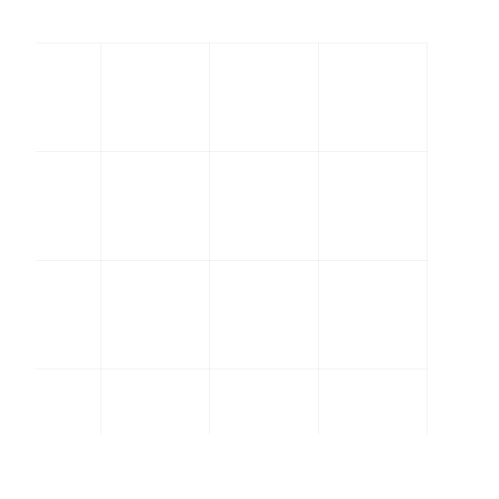

In [118]:
animate_graph(G, "static_graph_strategy", N_SOLS)

## Static strategy: edge selection

# Incremental dynamic strategy

##### Auxiliary functions

In [119]:
function count_all_known_solutions(G)
    count = 0
    for i in 1:length(G.vertices)
        count += length(G.vertices[i].known_roots)
    end
    return count
end

count_all_known_solutions (generic function with 1 method)

##### Augmentation methods

In [132]:
function augment_graph_petal(G, initial_vertex)
    # Create a new vertex
    new_vsystem = create_random_parameters()
    new_vertex = Vertex([], new_vsystem)
    add_Vertex(G, new_vertex)

    # Create two new edges
    for i=1:2
        k1,k2 = generate_generic_points(2)
        new_homotopy1 = createEdge(initial_vertex.base_point, new_vertex.base_point, k1,k2)
        new_tracker1 = Tracker(new_homotopy1)
        
        new_homotopy2 = createEdge(new_vertex.base_point, initial_vertex.base_point, k2, k1)
        new_tracker2 = Tracker(new_homotopy2)

        new_edge = Edge(initial_vertex, new_tracker1, new_vertex, new_tracker2, [k1, k2])
        add_Edge(G, new_edge)        
    end
end
    

augment_graph_petal (generic function with 1 method)

## Incremental dynamic
Stopping criterion: dynamic stability (select with max_stop_count)

Augmentation method: Add a petal to the initial vertex

In [133]:
function dynamic_incremental_strategy(G, max_stop_count=3, augment=(G)->G, N_SOLS=100, max_iter=12)
    it = 1
    stop_count = 0
    while it < max_iter
        println("-------------------Iteration", it, "-------------------")
        println("(History: ", length(G.history), ")")
        # Track the roots before
        sol_prev = length(G.vertices[1].known_roots)
        println("Known solutions: ", sol_prev)

        # Apply the static strategy
        println("<Applying static strategy...>")
        static_graph_strategy(G, N_SOLS)

        # Track the roots after
        sol_post = length(G.vertices[1].known_roots)
        println("Known solutions: ", sol_post)

        # If there are no new solutions, add to the stop count
        if sol_post == sol_prev
            println("No new solutions were found:  +1 stop counter.")
            stop_count += 1
            if stop_count == max_stop_count
                println("No new solutions were found in ", max_stop_count, " iterations.\n<Stopping>")
                break
            end
        else
            stop_count = 0
        end
        
        # Augment the graph
        println("<Augmenting graph...>")
        augment(G, G.vertices[1])

        it += 1
    end
    if it == max_iter
        println("Maximum number of iterations reached.")
    end
end

dynamic_incremental_strategy (generic function with 5 methods)

In [134]:
G = create_flower_graph((F0,x0), 1, 2);
dynamic_incremental_strategy(G, 3, augment_graph_petal, N_SOLS)

Created vertex: 1
Created vertex: 2
Created edge [1, 2]#1  (k1: 0.58 - 0.59im k2: -0.25 + 0.59im)
Created edge [1, 2]#2  (k1: -0.58 + 0.91im k2: -0.17 - 0.59im)
-------------------Iteration1-------------------
(History: 4)
Known solutions: 1
<Applying static strategy...>
--------------------------Edge [1, 2] has untracked roots----------------------
Tracking roots through path [1, 2]#1 from 1
No roots to track from 2.
--------------------------Edge [1, 2] has untracked roots----------------------
Tracking roots through path [1, 2]#2 from 1
Tracking roots through path [1, 2]#2 from 2
All possible roots have been tracked (for initial vertex 1 roots have been found).
Known solutions: 1
No new solutions were found:  +1 stop counter.
<Augmenting graph...>
Created vertex: 3
Created edge [1, 3]#1  (k1: -0.74 + 0.2im k2: 0.24 - 0.37im)
Created edge [1, 3]#2  (k1: 0.1 + 0.12im k2: -0.55 - 0.03im)
-------------------Iteration2-------------------
(History: 16)
Known solutions: 1
<Applying static 

Plots.AnimatedGif("/home/guillem911/OneDrive/Mathematics/GTDA/GTDA project/Presentation/Julia scripts/dynamic_incremental_strategy.gif")
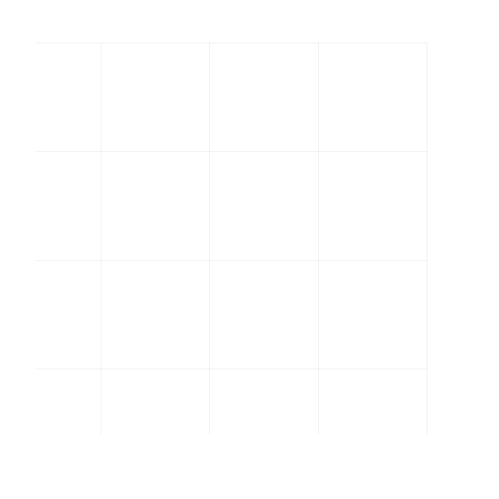

In [135]:
animate_graph(G, "dynamic_incremental_strategy", N_SOLS)

# Plot graphs

In [128]:
using Plots
function vertex_index(G, vertex)
    for i in 1:length(G.vertices)
        if G.vertices[i] == vertex
            return i
        end
    end
    return -1
end

function count_edges_between_vertices(G, v1, v2)
    count = 0
    for i in 1:length(G.edges)
        if G.edges[i].startV == v1 && G.edges[i].endV == v2
            count += 1
        end
    end
    return count
end

function generate_curved_line(x1,y1,x2,y2, num_points=100, p_schedule=0, schedule=[-0.07,0.07])
    if p_schedule == 0 || p_schedule > 2
        random_factor = rand(-0.2:0.01:0.2)
    else 
        random_factor = schedule[p_schedule]
    end
    if x1 == x2
        # Invert roles of x and y
        x1,y1,x2,y2 = y1,x1,y2,x2
    elseif x1 > x2
        # Make sure x1 < x2
        x1,y1,x2,y2 = x2,y2,x1,y1
    end
    x_values = range(x1, x2, length = num_points)
    y_values = y1 .+ (y2 .- y1) * (x_values .- x1) / (x2 .- x1)

    perpendicular_vector = [y2 - y1, x1 - x2] / sqrt((y2 - y1)^2 + (x1 - x2)^2) * random_factor

    x_values = x_values .+ sin.(range(0,pi,length=num_points)).^2 .* perpendicular_vector[1]
    y_values = y_values .+ sin.(range(0,pi,length=num_points)).^2 .* perpendicular_vector[2]

    if y1 == y2
        # Revert roles of x and y
        x_values, y_values = y_values, x_values
    end
    return x_values, y_values
end

function generate_arc(point1, point2, num_points)
    center = ((point1[1] + point2[1]) / 2, (point1[2] + point2[2]) / 2)
    radius = sqrt((point2[1] - point1[1])^2 + (point2[2] - point1[2])^2) / 2
    
    angle_start = atan(point1[2] - center[2], point1[1] - center[1])
    angle_end = atan(point2[2] - center[2], point2[1] - center[1])
    
    theta = range(angle_start, stop = angle_end, length = num_points)

    x_values = center[1] .+ radius .* cos.(theta)
    y_values = center[2] .+ radius .* sin.(theta)
    
    return x_values, y_values
end

function comb(n,m)
    return Int(factorial(n) / (factorial(m) * factorial(n-m)))
end
function plot_flower_graph(G, i, N_max=0, solution_count=0)
    G_state = G.history[i]
    N = length(G_state.vertex_labels)
    if N_max == 0
        N_max = N
    end
    if solution_count == 0
        solution_count_message = "?"
    else
        solution_count_message = string(solution_count)
    end
    # Generate coordinates for the vertices
    # Each vertex goes to a point in the unit circle
    theta = 2*pi/N_max
    x_coords = vcat([0.0], [cos(i*theta) for i in 1:(N-1)])
    y_coords = vcat([0.0], [sin(i*theta) for i in 1:(N-1)])

    plt = plot([],[], xlims=(-1.6,2), ylims=(-1.6,2), aspect_ratio=:equal, size=(500,500), showaxis=false, label="", legend=:outertopright)
    
    # Plot the vertices
    for i in 1:N
        if G_state.new_solution == i
            vertex_color = :red
        else
            vertex_color = :blue
        end
        scatter!([x_coords[i]], [y_coords[i]], color=vertex_color, ms=10, ma=0.5, label=string(G.vertices[i].label)*" - "*string(length(G_state.vertices[i].known_roots))*"/"*solution_count_message)
    end


    currently_tracking = length(G_state.path_tracking) > 0
    # Plot the edges
    for i in 1:length(G_state.edge_labels)
        startV = G_state.edge_labels[i][1]
        endV = G_state.edge_labels[i][2]
        # Plot a segment between the vertices
        if currently_tracking
            if G_state.path_tracking[1] == G_state.edge_labels[i] && G_state.path_tracking[2] == G.edges[i].label_id
                plot!(generate_curved_line(x_coords[startV],y_coords[startV], x_coords[endV], y_coords[endV], 100, G.edges[i].label_id), linecolor=:red, lw=2, legend=true, label = string(G.edges[i].label) *"#" * string(G.edges[i].label_id))
            else
                plot!(generate_curved_line(x_coords[startV],y_coords[startV], x_coords[endV], y_coords[endV], 100, G.edges[i].label_id), linecolor=:black, lw=2, legend=true, label = string(G.edges[i].label) *"#" * string(G.edges[i].label_id))
            end
        else
            plot!(generate_curved_line(x_coords[startV],y_coords[startV], x_coords[endV], y_coords[endV], 100, G.edges[i].label_id), linecolor=:black, lw=2,  legend=true, label = string(G.edges[i].label) *"#" * string(G.edges[i].label_id))
        end
    end
    return plt
end

function animate_graph(G, filename, sol_count)
    animate_G = Animation()
    n = length(G.history)
    N = length(G.history[end].vertex_labels)
    for i in range(1, n)
        plot_flower_graph(G, i, N, sol_count)
        frame(animate_G)
    end
    return gif(animate_G, filename*".gif", fps = 10);
end

animate_graph (generic function with 2 methods)